<a href="https://colab.research.google.com/github/nilum2002/Object-Detection-Using-RCNN/blob/main/src/FasterRCNNipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Object Detection: Faster R-CNN (RPN+ Fast R-CNN)
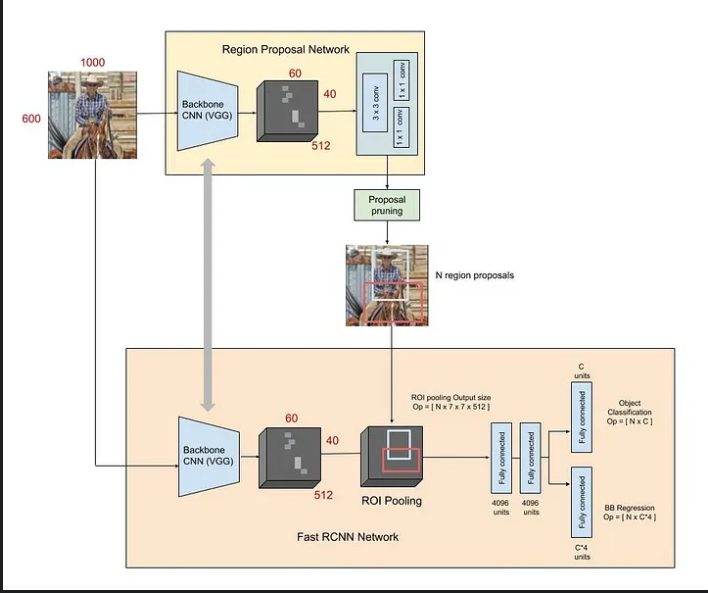

In [31]:
# Dataset path
path ="/content/drive/MyDrive/AquariumDataset"


In [32]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library
from tqdm.notebook import tqdm # Import tqdm for progress bars

import matplotlib.pyplot as plt
%matplotlib inline

PyCOCOTools provides many utilities for dealing with datasets in the COCO format, and if you wanted, you could evaluate the model's performance on the dataset with some of the utilities provided with this library.

In [33]:
# our dataset is in cocoformat, we will need pypcoco tools
!pip install pycocotools
from pycocotools.coco import COCO

In [34]:
# define the transformer
from albumentations.pytorch import ToTensorV2

In [35]:
def get_transformers(train=False):
  if train:
    transform = A.Compose([
        A.Resize(600, 600),
        A.HorizontalFlip(p=0.3),
        A.VerticalFlip(p=0.3),
        A.RandomBrightnessContrast(p=0.1),
        A.ColorJitter(p=0.1),
        ToTensorV2()
    ], bbox_params = A.BboxParams(format='coco'))
  else:
    transform = A.Compose([
        A.Resize(600, 600),
        ToTensorV2()
    ], bbox_params= A.BboxParams(format='coco'))
  return transform

We use albumentations as our data augmentation library due to its capability to deal with bounding boxes in multiple formats

In [36]:
# Datasets

class AquariumDetection(datasets.VisionDataset):
  def __init__(self, root, split = 'train', transform = None, target_transform =None, transforms = None):
    super().__init__(root, transforms, transform, target_transform)
    self.split = split
    self.coco = COCO(os.path.join(root, split, "_annotations.coco.json"))# annotation is here
    self.ids = list(sorted(self.coco.imgs.keys()))
    self.ids = [id for id in self.ids if (len(self._load_target(id))>0)]

  def _load_image(self, id:int):
    path = self.coco.loadImgs(id)[0]['file_name']
    image = cv2.imread(os.path.join(self.root, self.split, path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image
  def _load_target(self, id):
      return self.coco.loadAnns(self.coco.getAnnIds(id))

  def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        image = transformed['image']
        boxes = transformed['bboxes']
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images

  def __len__(self):
      return len(self.ids)


In [37]:
# load classes

coco = COCO(os.path.join(path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


{0: {'id': 0, 'name': 'creatures', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'fish', 'supercategory': 'creatures'},
 2: {'id': 2, 'name': 'jellyfish', 'supercategory': 'creatures'},
 3: {'id': 3, 'name': 'penguin', 'supercategory': 'creatures'},
 4: {'id': 4, 'name': 'puffin', 'supercategory': 'creatures'},
 5: {'id': 5, 'name': 'shark', 'supercategory': 'creatures'},
 6: {'id': 6, 'name': 'starfish', 'supercategory': 'creatures'},
 7: {'id': 7, 'name': 'stingray', 'supercategory': 'creatures'}}

In [38]:
# list of all classes
classes = [i[1]['name'] for i in categories.items()]
classes

['creatures',
 'fish',
 'jellyfish',
 'penguin',
 'puffin',
 'shark',
 'starfish',
 'stingray']

In [39]:
train_dataset = AquariumDetection(root=path, transforms=get_transformers(True))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Sample image and its bouding boxes, Not give the models output

/tmp/ipython-input-495388158.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)


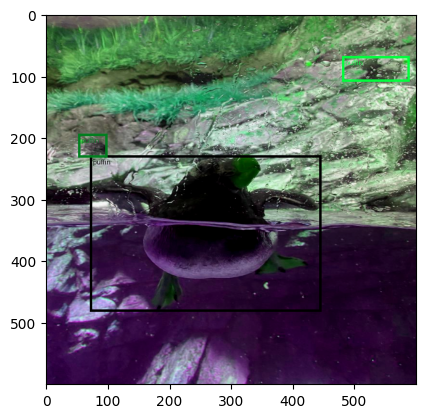

In [40]:
from torchvision.utils import draw_bounding_boxes

# Lets view a sample
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [41]:
# get the length of the dataset
len(train_dataset)

447

**Model Overview.** <br>

Our model is FasterRCNN with a backbone of MobileNetV3-Large. we need to change the output layers to 8. (we have 8 classes) But this model has 90 classes itself.


In [42]:
# load the faster RCNN model
model = models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
# change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


This is our collating function for the train dataloader, it allows us to create batches of data that can be easily pass into the model

In [43]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [44]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


The following blocks ensures that the model can take in the data and that it will not crash during training

In [45]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [46]:
device = torch.device("cuda") # use GPU to train

In [47]:
model = model.to(device)

**Optimizer **<br>
Here, we define the optimizer. If you wish, you can also define the LR Scheduler, but it is not necessary for this notebook since our dataset is so small.


In [48]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [49]:
import sys

**Training** <br>
The following is a function that will train the model for one epoch. Torchvision Object Detections models have a loss function built in, and it will calculate the loss automatically if you pass in the inputs and targets

In [50]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)

#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

#         if lr_scheduler is not None:
#             lr_scheduler.step() #

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [56]:
num_epochs=20

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()

  0%|          | 0/112 [00:00<?, ?it/s]

/tmp/ipython-input-1196992776.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]


Epoch 0, lr: 0.010000, loss: 0.769882, loss_classifier: 0.277598, loss_box: 0.413528, loss_rpn_box: 0.033725, loss_object: 0.045031


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 1, lr: 0.010000, loss: 0.780642, loss_classifier: 0.288884, loss_box: 0.413062, loss_rpn_box: 0.033172, loss_object: 0.045525


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 2, lr: 0.010000, loss: 0.784003, loss_classifier: 0.289500, loss_box: 0.416143, loss_rpn_box: 0.033443, loss_object: 0.044918


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 3, lr: 0.010000, loss: 0.857058, loss_classifier: 0.311832, loss_box: 0.467509, loss_rpn_box: 0.033101, loss_object: 0.044617


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 4, lr: 0.010000, loss: 0.772937, loss_classifier: 0.268724, loss_box: 0.428947, loss_rpn_box: 0.032189, loss_object: 0.043078


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 5, lr: 0.010000, loss: 0.809205, loss_classifier: 0.283309, loss_box: 0.451003, loss_rpn_box: 0.032372, loss_object: 0.042520


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 6, lr: 0.010000, loss: 0.810933, loss_classifier: 0.280488, loss_box: 0.458189, loss_rpn_box: 0.032164, loss_object: 0.040092


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 7, lr: 0.010000, loss: 0.845251, loss_classifier: 0.287016, loss_box: 0.487647, loss_rpn_box: 0.030994, loss_object: 0.039594


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 8, lr: 0.010000, loss: 0.830559, loss_classifier: 0.281787, loss_box: 0.480075, loss_rpn_box: 0.030886, loss_object: 0.037812


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 9, lr: 0.010000, loss: 0.812428, loss_classifier: 0.277333, loss_box: 0.464116, loss_rpn_box: 0.030785, loss_object: 0.040194


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 10, lr: 0.010000, loss: 0.833621, loss_classifier: 0.284357, loss_box: 0.480253, loss_rpn_box: 0.030669, loss_object: 0.038342


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 11, lr: 0.010000, loss: 0.847316, loss_classifier: 0.293121, loss_box: 0.486401, loss_rpn_box: 0.030458, loss_object: 0.037337


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 12, lr: 0.010000, loss: 0.811801, loss_classifier: 0.271800, loss_box: 0.472253, loss_rpn_box: 0.030074, loss_object: 0.037673


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 13, lr: 0.010000, loss: 0.847279, loss_classifier: 0.280913, loss_box: 0.500806, loss_rpn_box: 0.029202, loss_object: 0.036358


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 14, lr: 0.010000, loss: 0.853650, loss_classifier: 0.281012, loss_box: 0.509236, loss_rpn_box: 0.028632, loss_object: 0.034770


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 15, lr: 0.010000, loss: 0.837293, loss_classifier: 0.281773, loss_box: 0.489593, loss_rpn_box: 0.029413, loss_object: 0.036514


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 16, lr: 0.010000, loss: 0.815209, loss_classifier: 0.260158, loss_box: 0.489095, loss_rpn_box: 0.029607, loss_object: 0.036348


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 17, lr: 0.010000, loss: 0.803710, loss_classifier: 0.271615, loss_box: 0.469727, loss_rpn_box: 0.028484, loss_object: 0.033884


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 18, lr: 0.010000, loss: 0.826127, loss_classifier: 0.274075, loss_box: 0.489817, loss_rpn_box: 0.028426, loss_object: 0.033809


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 19, lr: 0.010000, loss: 0.848685, loss_classifier: 0.282285, loss_box: 0.506142, loss_rpn_box: 0.028430, loss_object: 0.031828


**Trying on Sample images**
<br>
This is the inference code for the model. First, we set the model to evaluation mode and clear the GPU Cache. We also load a test dataset, so that we can use fresh images that the model hasn't seen

In [52]:
# we will watch first epoich to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

In [53]:
test_dataset = AquariumDetection(root=path, split="test", transforms=get_transformers(False))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [54]:
img, _ = test_dataset[5]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    model.eval() # Ensure the model is in evaluation mode
    prediction = model([img.to(device)])
    pred = prediction[0]

/tmp/ipython-input-416449017.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_int = torch.tensor(img*255, dtype=torch.uint8)


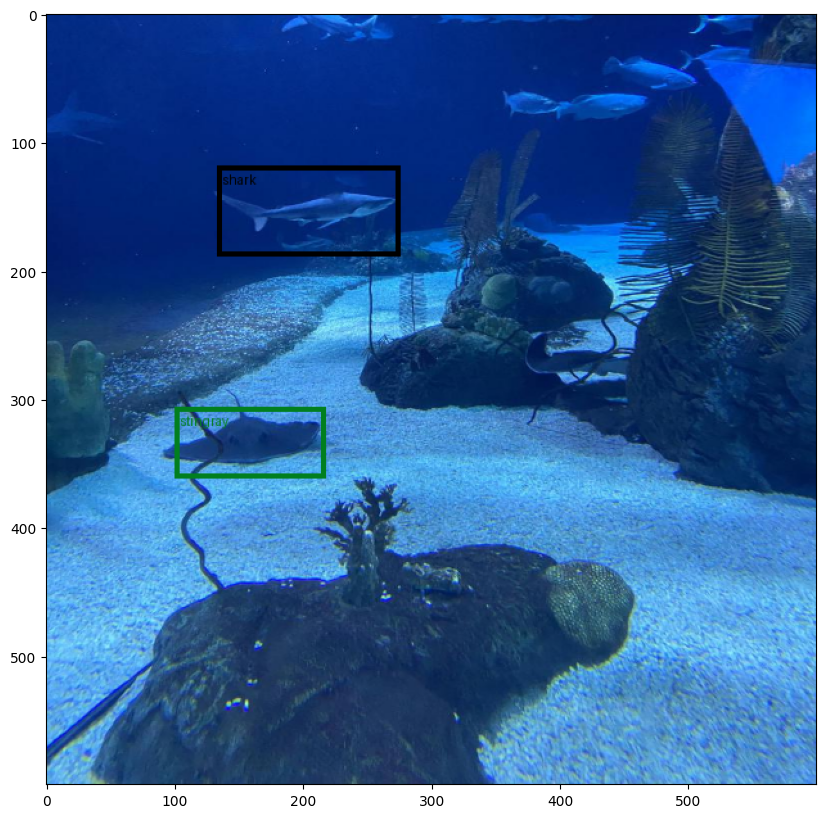

In [55]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))